In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.append("/scratch/jho5ze/bionets/covid/scripts")
import entropy_utils as eu
from math import ceil, floor

In [2]:
def get_entropy(msa):
    graph, genomes = eu.generate_nx_from_msa(msa)
    eu.add_root(graph, genomes)
    collapsed_graph = eu.collapse_graph(graph)

    eu.annotate_graph(graph)
    eu.annotate_graph(collapsed_graph)

    graph_presence_info = eu.get_genome_node_presence(graph, genomes)
    collapsed_graph_presence_info = eu.get_genome_node_presence(collapsed_graph, genomes)

    columns = []
    values = []

    # iter_info = zip([aa_graph, aa_collapsed_graph], ["aa_full", "aa_collapsed"], [aa_graph_presence_info, aa_collapsed_graph_presence_info])

    iter_info = zip([graph, collapsed_graph], ["full", "collapsed"], [graph_presence_info, collapsed_graph_presence_info])

    for G, graph_name, presence_info in iter_info:
        for seqs in range(2):
            seq_name = f"_sequences_{seqs}"
            for genomes in range(2):
                if "full" in graph_name:
                    if not (seqs ^ genomes):#full_both and full_none reduce to full_genomes and full_seq, respectively
                        continue
                genome_name = f"_genomes_{genomes}"
                columns.append(graph_name + seq_name + genome_name)
                uncert = str(eu.calc_uncertainty(G, presence_info, weigh_on_sequence=seqs, weigh_on_genomes=genomes))
                values.append(uncert)
    return pd.DataFrame.from_records(list(zip(columns, values)), columns = ["model", "entropy"]).set_index("model")

In [12]:
node_prop_examples = [] #total_genomes, num_paths, num_nodes, prop in greatest path, model, entropy

with open("/scratch/jho5ze/bionets/covid/data/msa_0408/reference_msa.txt") as src:
    reference_line = src.readlines()[0].replace("-", "")[:50]

"""
Assume 10 paths
"""
total_genomes = 100
num_paths = 10
for new_nodes in [10, 20, 50, 100]: #,200,500,1000,10000]:
    for max_prop in [0.1,0.5,0.9]:
        msa = []
        num_new_nodes_per = new_nodes // num_paths
        for ix in range(num_paths):
#             mutation_step = (ix*3) + (num_new_nodes_per)
            if ix == 0:
                num_genomes = max_prop * total_genomes
            else:
                num_genomes = max(1, floor((1-max_prop) / (num_paths - 1) * total_genomes))
            sequence = reference_line
            for pos in range(0, len(reference_line), floor(len(reference_line) / num_new_nodes_per)):
                pos += ix
                try:
                    char = sequence[pos]
                except:
                    continue
                new_char = "C" if char == "A" else "A"
                sequence = sequence[:pos] + new_char + sequence[pos+1:]
            for i in range(int(num_genomes)):
                msa.append(f">seq_{ix}")
                msa.append(sequence)
        msa = "\n".join(msa)
        for i in  get_entropy(msa).reset_index().to_numpy():
            node_prop_examples.append((total_genomes, num_paths, new_nodes, max_prop, i[0], i[1]))
#         break
#     break
    
# print(node_prop_examples)

total_results = pd.DataFrame.from_records(node_prop_examples, columns=["total_genomes", "num_paths", "new_nodes", "max_prop", "model", "entropy"])
total_results.entropy = total_results.entropy.astype(float)

In [14]:
num_genomes

1

In [57]:
print(reference_line)

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTC


In [56]:
print(msa)

>seq_0
CTTAACGGTTAATACATTCCAAGGTCACAACCCAAACAACATTCGCTCTC
>seq_1
AATAAAAGTTTCTACCATCCCCGGTACCAAAACAACAAACTATCGAACTC
>seq_2
ATAAAAGATTTAAACCTACCCAAGTAAAAAACAAACCCACTTACGATATC
>seq_3
ATTCAAGGATTATCCCTTACCAGATAACCAACCCACCACCTTTAGATCAC
>seq_4
ATTACAGGTATATAACTTCACAGGAAACACACCACCCAAATTTCAATCTA
>seq_5
ATTAACGGTTAATACATTCCAAGGTCACAACCCAAACAACATTCGCTCTC
>seq_6
ATTAAAAGTTTCTACCATCCCCGGTACCAAAACAACAAACTATCGAACTC
>seq_7
ATTAAAGATTTAAACCTACCCAAGTAAAAAACAAACCCACTTACGATATC
>seq_8
ATTAAAGGATTATCCCTTACCAGATAACCAACCCACCACCTTTAGATCAC
>seq_9
ATTAAAGGTATATAACTTCACAGGAAACACACCACCCAAATTTCAATCTA


In [9]:
total_results.to_csv("output/10_to_100_and_frequency_calc.csv", index=False)

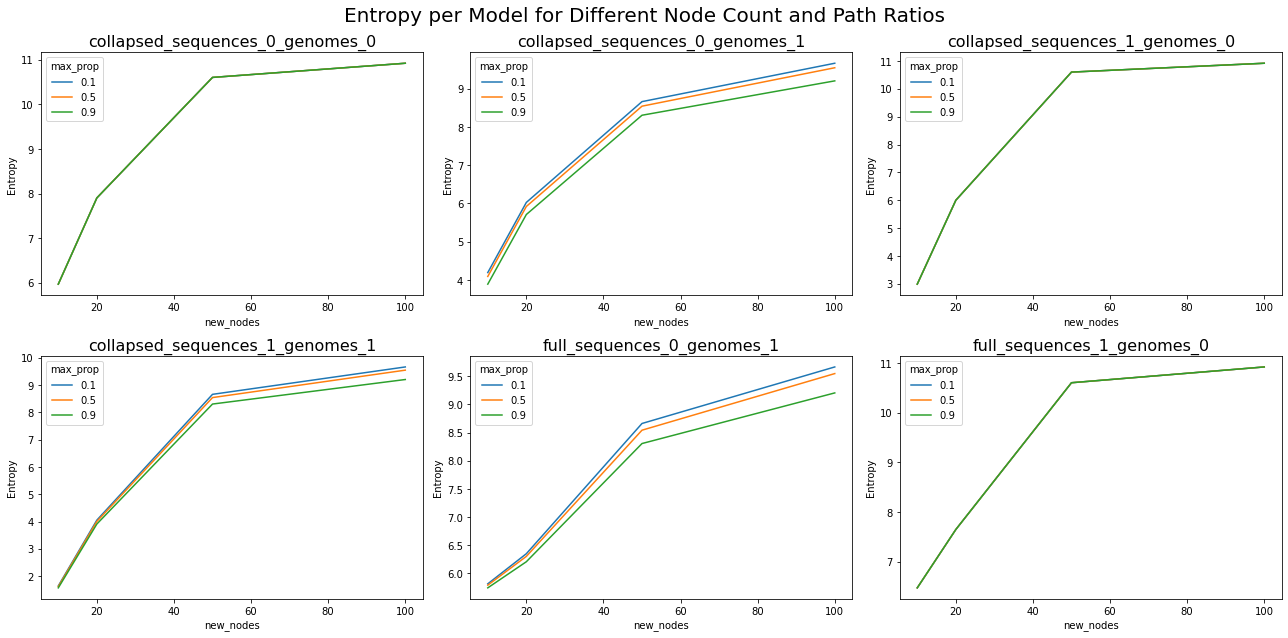

In [15]:
fig, axs = plt.subplots(2,3, figsize=(18,9))
# total_results = pd.DataFrame.from_records(node_prop_examples, columns=["total_genomes", "num_paths", "new_nodes", "max_prop", "model", "entropy"])
# total_results.entropy = total_results.entropy.astype(float)

ix = 0
for model, df in total_results.groupby("model"):
    ax = axs[ix//3, ix%3]
    ix += 1
    df.pivot(index="new_nodes", columns="max_prop", values="entropy").plot(ax=ax)
    ax.set_title(model, fontsize=16)
    ax.set_ylabel("Entropy")
plt.suptitle("Entropy per Model for Different Node Count and Path Ratios", fontsize=20)
plt.tight_layout()
plt.savefig("output/entropy_spread_for_node_and_frequency_changes_small_10_100.png", dpi=100, bbox_inches="tight")

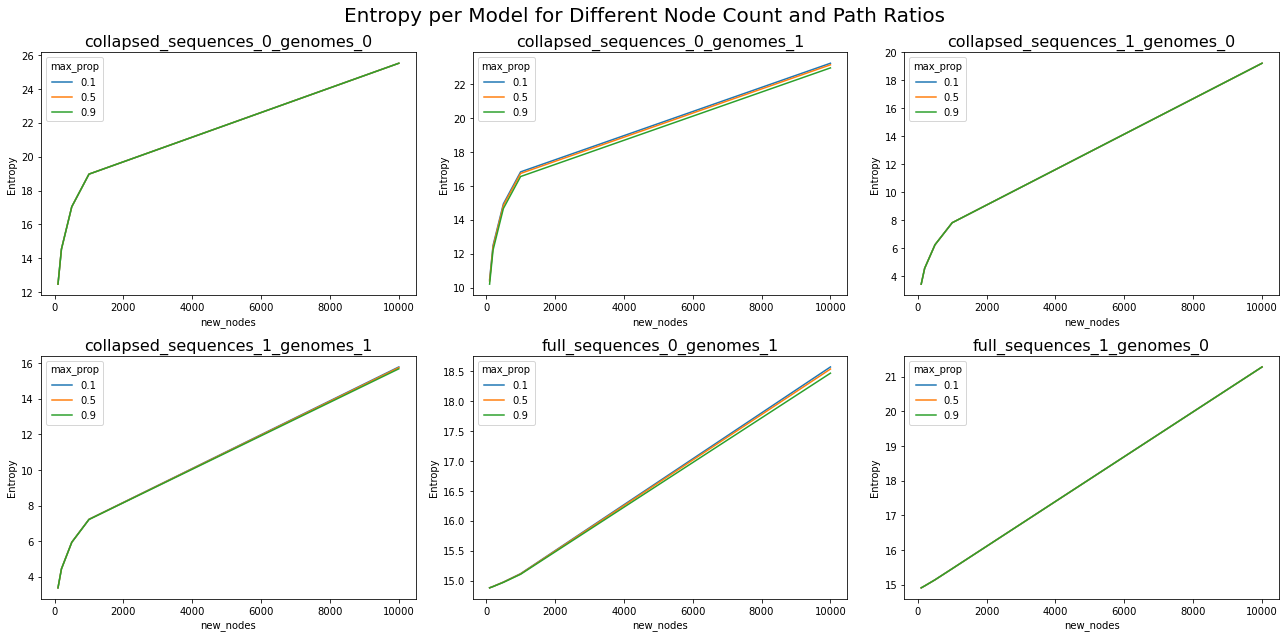

In [58]:
fig, axs = plt.subplots(2,3, figsize=(18,9))
# total_results = pd.DataFrame.from_records(node_prop_examples, columns=["total_genomes", "num_paths", "new_nodes", "max_prop", "model", "entropy"])
# total_results.entropy = total_results.entropy.astype(float)

ix = 0
for model, df in total_results.groupby("model"):
    ax = axs[ix//3, ix%3]
    ix += 1
    df.pivot(index="new_nodes", columns="max_prop", values="entropy").plot(ax=ax)
    ax.set_title(model, fontsize=16)
    ax.set_ylabel("Entropy")
plt.suptitle("Entropy per Model for Different Node Count and Path Ratios", fontsize=20)
plt.tight_layout()
plt.savefig("output/entropy_spread_for_node_and_frequency_changes.png", dpi=100, bbox_inches="tight")

In [38]:
total_results[total_results.max_prop == 0.9]

,total_genomes,num_paths,new_nodes,max_prop,model,entropy
12,50,10,100,0.9,full_sequences_0_genomes_1,14.867424
13,50,10,100,0.9,full_sequences_1_genomes_0,14.867424
14,50,10,100,0.9,collapsed_sequences_0_genomes_0,0.000000
15,50,10,100,0.9,collapsed_sequences_0_genomes_1,0.000000
16,50,10,100,0.9,collapsed_sequences_1_genomes_0,0.000000
17,50,10,100,0.9,collapsed_sequences_1_genomes_1,0.000000
30,50,10,200,0.9,full_sequences_0_genomes_1,14.867424
31,50,10,200,0.9,full_sequences_1_genomes_0,14.867424
32,50,10,200,0.9,collapsed_sequences_0_genomes_0,0.000000
33,50,10,200,0.9,collapsed_sequences_0_genomes_1,0.000000


In [6]:
reference_line

'ATTAAAGGTTTATACCTTCCCAGGTAACAA'

In [23]:
for i in  get_entropy(msa).reset_index().to_numpy():
    print((new_nodes, max_prop, i[0], i[1]))

(100, 0.1, 'full_sequences_0_genomes_1', '4.321928094887363')
(100, 0.1, 'full_sequences_1_genomes_0', '4.321928094887363')
(100, 0.1, 'collapsed_sequences_0_genomes_0', '0.0')
(100, 0.1, 'collapsed_sequences_0_genomes_1', '0.0')
(100, 0.1, 'collapsed_sequences_1_genomes_0', '0.0')
(100, 0.1, 'collapsed_sequences_1_genomes_1', '0.0')


In [5]:
small_msa = ""
for i in range(2):
    small_msa += f">seq_{i}\nAAATTTCCCGGGAAATTTCCCGGG\n"
for i in range(2):
    small_msa += f">seq_{i}\nAAACCCTTTGGGAAATTTCCCGGG\n"
# print(small_msa)
get_entropy(small_msa)

,entropy
model,
full_sequences_0_genomes_1,4.834962500721154
full_sequences_1_genomes_0,4.906890595608519
collapsed_sequences_0_genomes_0,2.0
collapsed_sequences_0_genomes_1,1.9182958340544896
collapsed_sequences_1_genomes_0,1.7609640474436812
collapsed_sequences_1_genomes_1,1.5487949406953985


In [6]:
small_msa = ""
for i in range(100):
    small_msa += f">seq_{i}\nAAATTTCCCGGGAAATTTCCCGGG\n"
for i in range(100):
    small_msa += f">seq_{i}\nAAACCCTTTGGGAAATTTCCCGGG\n"
# print(small_msa)
get_entropy(small_msa)

,entropy
model,
full_sequences_0_genomes_1,4.834962500721154
full_sequences_1_genomes_0,4.906890595608519
collapsed_sequences_0_genomes_0,2.0
collapsed_sequences_0_genomes_1,1.9182958340544896
collapsed_sequences_1_genomes_0,1.7609640474436812
collapsed_sequences_1_genomes_1,1.5487949406953985


In [7]:
small_msa = ""
for i in range(200):
    small_msa += f">seq_{i}\nAAATTTCCCGGGAAATTTCCCGGG\n"
for i in range(100):
    small_msa += f">seq_{i}\nAAACCCTTTGGGAAATTTCCCGGG\n"
# print(small_msa)
get_entropy(small_msa)

,entropy
model,
full_sequences_0_genomes_1,4.814536459234777
full_sequences_1_genomes_0,4.906890595608519
collapsed_sequences_0_genomes_0,2.0
collapsed_sequences_0_genomes_1,1.8910611120726526
collapsed_sequences_1_genomes_0,1.7609640474436812
collapsed_sequences_1_genomes_1,1.528368899209021


### Past Demo

In [87]:
%run /scratch/jho5ze/bionets/covid/scripts/entropy_utils.py

In [95]:
def plot_edge_weights(G, thresh=1, seed=7):
    fig, ax = plt.subplots(figsize=(8,6))
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]
    
    pos = nx.spring_layout(G, seed=seed)
    
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=600, ax=ax)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, style="dashed", ax=ax)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", ax=ax)

In [133]:
def report_entropy(graph, genomes):
    presence_info = get_genome_node_presence(graph, genomes)
    for seqs in range(2):
        seq_name = f"_sequences_{seqs}"
        for genomes in range(2):
            seq_str = " sequences" if seqs else ""
            genomes_str = " genomes" if genomes else ""
            label_str = f"Weighted by{seq_str.upper()}{genomes_str.upper()}: "
            entropy = calc_uncertainty(graph, presence_info, weigh_on_sequence=seqs, weigh_on_genomes=genomes)
            print(f"{label_str}\n\t{entropy}")
            
def get_example_graphs(msa):
    #Build graph from string MSA
    two_seq_graph, two_seq_genomes = generate_nx_from_msa(msa)
    #Add a root, if none exists
    add_root(two_seq_graph, two_seq_genomes)
    #Collapse the graph (combine all edges between nodes with parent out and child in degree 1)
    collapsed_two_graph = collapse_graph(two_seq_graph)
    #Add feature "sequence_len" to graph
    annotate_graph(two_seq_graph)
    annotate_graph(collapsed_two_graph)
    return two_seq_graph, collapsed_two_graph, two_seq_genomes

### Full graph

In [211]:
bottom_seq = "GTCACC"
top_seq = "ATCAAC"

single_msa = f"""
>top_seq0
{top_seq}
"""

two_msa = f"""
>bottom_seq0
{bottom_seq}
>top_seq0
{top_seq}
"""

many_msa = "\n".join([f">bottom_seq0\n{bottom_seq}"] + \
                     [f">top_seq{ix}\n{top_seq}" for ix in range(10)])
# print("Two: \n", two_msa)
# print("Many: \n", many_msa)

#### Single seq

In [212]:
single_full, single_collapsed, single_genomes = get_example_graphs(single_msa)
print("Full")
report_entropy(single_full, single_genomes)

Full
Weighted by: 
	2.584962500721156
Weighted by GENOMES: 
	2.584962500721156
Weighted by SEQUENCES: 
	2.584962500721156
Weighted by SEQUENCES GENOMES: 
	2.584962500721156


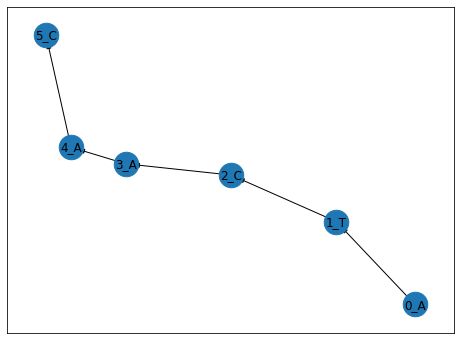

In [213]:
plot_edge_weights(single_full, seed=21)

#### Two seqs

In [215]:
two_full, two_collapsed, two_genomes = get_example_graphs(two_msa)
print("Full")
report_entropy(two_full, two_genomes)

Full
Weighted by: 
	3.6143694458867555
Weighted by GENOMES: 
	3.378783493486176
Weighted by SEQUENCES: 
	3.6143694458867555
Weighted by SEQUENCES GENOMES: 
	3.378783493486176


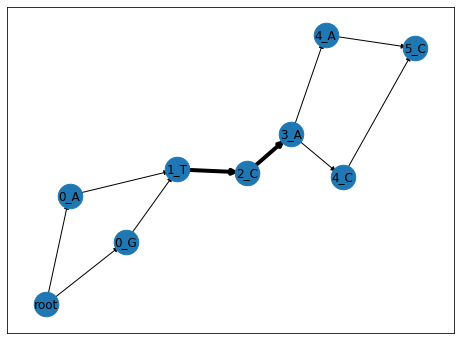

In [216]:
plot_edge_weights(two_full, seed=21)

#### Many seqs

In [217]:
many_full, many_collapsed, many_genomes = get_example_graphs(many_msa)
print("Full")
report_entropy(many_full, many_genomes)

Full
Weighted by: 
	3.6143694458867555
Weighted by GENOMES: 
	3.2186397754637515
Weighted by SEQUENCES: 
	3.6143694458867555
Weighted by SEQUENCES GENOMES: 
	3.2186397754637515


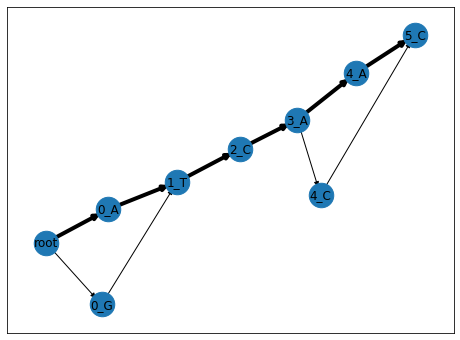

In [218]:
plot_edge_weights(many_full, seed=21)

### Collapsed graph

In [224]:
bottom_seq = "GGGTTTCCCAAACCCCCC"
top_seq = "AAATTTCCCAAAAAACCC"

single_msa = f"""
>top_seq0
{top_seq}
"""

two_msa = f"""
>bottom_seq0
{bottom_seq}
>top_seq0
{top_seq}
"""

many_msa = "\n".join([f">bottom_seq0\n{bottom_seq}"] + \
                     [f">top_seq{ix}\n{top_seq}" for ix in range(10)])
# print("Two: \n", two_msa)
# print("Many: \n", many_msa)

#### Single seq

In [225]:
single_full, single_collapsed, single_genomes = get_example_graphs(single_msa)

In [226]:
print("Full")
report_entropy(single_full, single_genomes)

Full
Weighted by: 
	4.169925001442313
Weighted by GENOMES: 
	4.169925001442313
Weighted by SEQUENCES: 
	4.169925001442313
Weighted by SEQUENCES GENOMES: 
	4.169925001442313


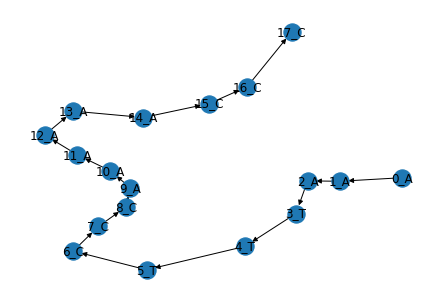

In [227]:
nx.draw_spring(single_full, with_labels=True)

In [230]:
print("Collapsed")
report_entropy(single_collapsed, two_genomes)

Collapsed
Weighted by: 
	0.0
Weighted by GENOMES: 
	0.0
Weighted by SEQUENCES: 
	0.0
Weighted by SEQUENCES GENOMES: 
	0.0


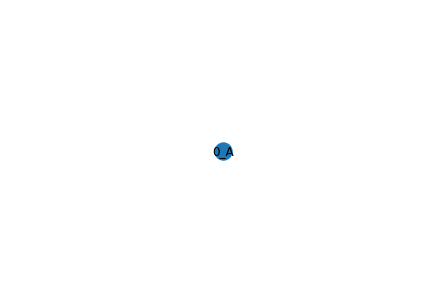

In [229]:
nx.draw_spring(single_collapsed, with_labels=True)

#### Two seqs

In [137]:
two_full, two_collapsed, two_genomes = get_example_graphs(two_msa)

In [138]:
print("Full")
report_entropy(two_full, two_genomes)

Full
Weighted by: 
	5.884638190120872
Weighted by GENOMES: 
	5.380020934723953
Weighted by SEQUENCES: 
	5.884638190120872
Weighted by SEQUENCES GENOMES: 
	5.380020934723953


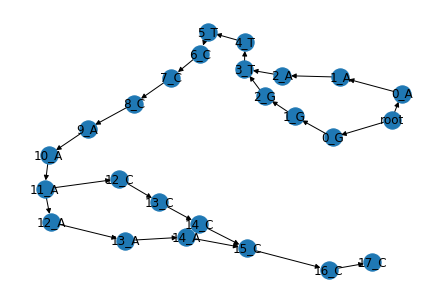

In [51]:
#nx.draw_spring(two_seq_graph, with_labels=True)

In [139]:
print("Collapsed")
report_entropy(two_collapsed, two_genomes)

Collapsed
Weighted by: 
	3.3787834934861762
Weighted by GENOMES: 
	3.121928094887362
Weighted by SEQUENCES: 
	3.031705688822799
Weighted by SEQUENCES GENOMES: 
	2.627191328208259


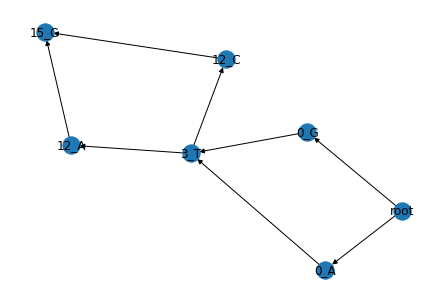

In [61]:
nx.draw_spring(collapsed_two_graph, with_labels=True)

### Many seqs

In [140]:
many_full, many_collapsed, many_genomes = get_example_graphs(many_msa)

In [141]:
print("Full")
report_entropy(many_full, many_genomes)

Full
Weighted by: 
	5.884638190120872
Weighted by GENOMES: 
	5.2030199832254835
Weighted by SEQUENCES: 
	5.884638190120872
Weighted by SEQUENCES GENOMES: 
	5.2030199832254835


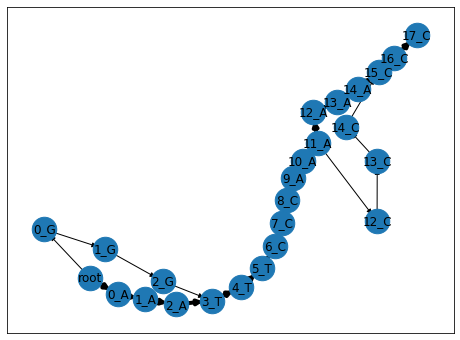

In [198]:
plot_edge_weights(many_full, seed=21)

In [199]:
print("Collapsed")
report_entropy(many_collapsed, many_genomes)

Collapsed
Weighted by: 
	3.3787834934861762
Weighted by GENOMES: 
	2.8977268896559676
Weighted by SEQUENCES: 
	3.031705688822799
Weighted by SEQUENCES GENOMES: 
	2.4501903767097892


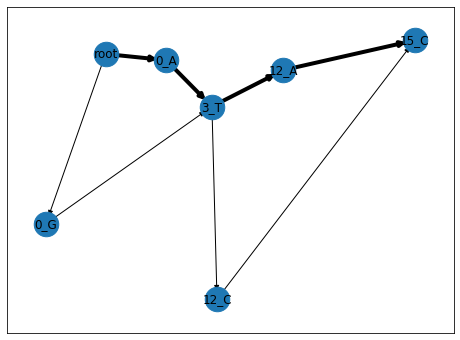

In [207]:
plot_edge_weights(many_collapsed, seed=15)